In [2]:
%run ../../utils/helper.ipynb
import matplotlib.pyplot as plt
import itertools
plt.rcParams.update({
    "text.usetex": True,
})
plt.style.use("science")

Welcome to JupyROOT 6.22/06


Matplotlib created a temporary config/cache directory at /tmp/matplotlib-5h2a13qp because the default path (/home/jovyan/.cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


In [3]:
project_dir = "/work/clas12/users/gmat/clas12/clas12_dihadrons/projects"
project_name = "ana_v1"
latex_dir = f"{project_dir}/{project_name}/plots/asym_pw"

In [3]:
#create_asym_yaml("../../macros/bru/","proj_temp",path="../../macros/bru/proj_temp/volatile/asym")
#create_asym_yaml(project_dir,project_name)

In [4]:
data = get_asym_yaml(project_dir,project_name)

In [5]:
def get_letter(twist, row,col):
    l,m = lm(twist,row,col)
    if twist == "twist-2":
        if (l, m) == (2, 1):
            return "H"
        elif (l, m) == (2, 2):
            return "E"
        elif (l, m) == (1, 1):
            return "K"
        else:
            raise ValueError("Invalid l,m values for Twist-2. Allowed values: (2, 1), (2, 2), (1, 1)")
            
    elif twist == "twist-3":
        if (l, m) == (2, -1):
            return "I"
        elif (l, m) == (1, -1):
            return "L"
        elif (l, m) == (2, -2):
            return "F"
        elif (l, m) == (0, 0):
            return "A"
        elif (l, m) == (2, 0):
            return "B"
        elif (l, m) == (2, 2):
            return "D"
        elif (l, m) == (2, 1):
            return "G"
        elif (l, m) == (1, 1):
            return "J"
        elif (l, m) == (1, 0):
            return "C"
        else:
            raise ValueError(f"Invalid l,m {l,m} values for Twist-3. Allowed values: (2, 1), (1, -1), (2, -2), (0, 0), (2, 0), (2, 2), (2, 1), (1, 1), (1, 0)")
            
    else:
        raise ValueError("Invalid twist value. Allowed values: 'twist-2', 'twist-3'")


In [6]:
def lm(twist,row,col):
    if twist=="twist-2":
        l=row+1
        m=col+1
    elif twist=="twist-3":
        l=row+1
        m=(col-2 if col<=1 else col -1)
    return l,m

def braket(twist,row,col):
    l,m=lm(twist,row,col)
    return f"|{l},{m}"+r"\rangle"   

def pw_label(twist,row,col):
    l,m=lm(twist,row,col)
    if twist=="twist-2":
        if(l==1 and m==1):
            return "G^{\perp}_{1,O\,T}"
        elif(l==2 and m==1):
            return "G^{\perp}_{1,L\,T}"
        elif(l==2 and m==2):
            return "G^{\perp}_{1,T\,T}"
    elif twist=="twist-3":
        if(m<0):
            H="H^{\perp}"
        else:
            H="H^{\sphericalangle}"
        
        if(l==1):
            return H+"_{1,O\,T}"
        elif(l==2 and abs(m)==2):
            return H+"_{1,T\,T}"
        elif(l==2 and abs(m)==1):
            return H+"_{1,L\,T}"
    else:
        print("?")
        return 0

In [22]:
def get_y_limits(twist, dict_base, drop_edges=False):
    y_limits = []
    if twist == "twist-2":
        for row in range(2):
            y_mins = []
            y_maxs = []
            for col in range(2):
                if row == 0 and col == 1:
                    continue
                letter = get_letter(twist, row, col)
                x_data, y_data, error_data = extract_data(dict_base, letter, drop_edges=drop_edges)
                y_mins += list(y_data-np.abs(error_data))
                y_maxs += list(y_data+np.abs(error_data))
            y_limits.append((np.amin(y_mins),np.amax(y_maxs)))
    elif twist == "twist-3":
        for row in range(2):
            y_mins = []
            y_maxs = []
            for col in range(4):
                if (row == 0 and col in [0,3]):
                    continue
                letter = get_letter(twist, row, col)
                x_data, y_data, error_data = extract_data(dict_base, letter, drop_edges=drop_edges)
                y_mins += list(y_data-np.abs(error_data))
                y_maxs += list(y_data+np.abs(error_data))
            y_limits.append((np.amin(y_mins),np.amax(y_maxs)))
            
    return y_limits

In [62]:
def widen_x_limits(ax, x_data, factor=1.1):
    x_range = max(x_data) - min(x_data)
    x_pad = x_range * (factor - 1) / 2
    new_x_limits = (min(x_data) - x_pad, max(x_data) + x_pad)
    ax.set_xlim(new_x_limits)
    
def widen_y_limits(ax, y_data, factor=1.1):
    y_range = max(y_data) - min(y_data)
    y_pad = y_range * (factor - 1) / 2
    new_y_limits = [min(y_data) - y_pad, max(y_data) + y_pad]
    old_y_limits = [ax.get_ylim()[0],ax.get_ylim()[1]]
    if(old_y_limits[0]<new_y_limits[0]):
        new_y_limits[0]=old_y_limits[0]
    if(old_y_limits[1]>new_y_limits[1]):
        new_y_limits[1]=old_y_limits[1]
    ax.set_ylim(tuple(new_y_limits))

In [63]:
def extract_data(dict_base, letter, drop_edges=False):
    x_data = dict_base["x"]
    y_data = dict_base[letter]["value"]
    error_data = dict_base[letter]["error"]
    # Sort data by x-values
    sorted_data = sorted(zip(x_data, y_data, error_data))
    x_data, y_data, error_data = zip(*sorted_data)
    if drop_edges:
        x_data = x_data[1:-1]
        y_data = y_data[1:-1]
        error_data = error_data[1:-1]
    filtered_data = [(x, y, err) for x, y, err in zip(x_data, y_data, error_data) if err <= 0.1]
    x_data, y_data, error_data = zip(*filtered_data)
    
    return np.array(x_data), np.array(y_data), np.array(error_data)

In [64]:

def plot_PW(twist, data, headers_list, drop_edges=True,out_plot="",custom_labels=[]):
    dict_base = data
    for header in headers_list[0]:
        dict_base = dict_base[header]

    y_limits = get_y_limits(twist, dict_base, drop_edges)
    #y_limits = ((-0.08,0.08),(-0.08,0.08))
    x_label = format_x_label(headers_list[0][3])
    if twist == "twist-2":
        fig, axes = create_twist2_axes(y_limits,x_label)
    elif twist == "twist-3":
        fig, axes = create_twist3_axes(y_limits,x_label)
    else:
        raise ValueError("Invalid twist value. Allowed values: 'twist-2', 'twist-3'")
        
    legend_handles_labels = []
    
    for row in range(axes.shape[0]):
        for col in range(axes.shape[1]):
            if axes[row, col] is None:
                continue

            for headers in headers_list:
                handle, label = plot_on_subplot(twist, data, headers, axes, row, col, drop_edges)
                legend_handles_labels.append((handle, label))
                
    # Remove duplicate legend entries
    #handles, labels = zip(*legend_handles_labels)
    handles, labels = axes[1,1].get_legend_handles_labels()
    _, unique_indices = np.unique(labels, return_index=True)
    unique_handles = [handles[i] for i in unique_indices]
    unique_labels = [labels[i] for i in unique_indices]
    
    if(custom_labels):
        unique_labels=[format_dihadron_label(cl) for cl in custom_labels]
        
    # Create the legend for the entire figure in the top right corner
    tmpplot=(0,2) if twist=="twist-3" else (0,0)
    axes[tmpplot].legend(unique_handles, unique_labels, loc="upper left", bbox_to_anchor=(1, 1), fontsize=("medium" if custom_labels else "x-small"), title_fontsize="small")

    fig.suptitle(twist.replace("twist","Twist")+r" $A_{LU}$ Amplitudes")
    
    
    if(out_plot):
        plt.savefig(out_plot)
        plt.close()
    else:
        plt.show()


def create_twist2_axes(y_limits,x_label):
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(4, 4), dpi=250)
    fig.delaxes(axes[0, 1])
    axes[0,1]=None
    plt.subplots_adjust(wspace=0, hspace=0)
    configure_axes(axes, y_limits,x_label,2)
    return fig, axes


def create_twist3_axes(y_limits,x_label):
    fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(8, 4), dpi=250)
    fig.delaxes(axes[0, 0])
    fig.delaxes(axes[0, 3])
    axes[0,0]=None
    axes[0,3]=None
    plt.subplots_adjust(wspace=0, hspace=0)
    configure_axes(axes, y_limits,x_label,3)
    return fig, axes


def configure_axes(axes, y_limits,x_label,twist):
    for row in range(axes.shape[0]):
        for col in range(axes.shape[1]):
            l,m = lm("twist-{}".format(twist),row,col)
            y_label=f"A_{{LU}}^{{|{l},m\\rangle}}"
            
            if axes[row, col] is None:
                continue
            axes[row, col].set_ylim(y_limits[row])
            if row == 1:
                axes[row, col].set_xlabel(r"{}".format(x_label))
            if row == 0:
                axes[row, col].xaxis.set_ticklabels([])
            if twist==2:
                if col != 0:
                    axes[row, col].yaxis.set_ticklabels([])
                else:
                    axes[row,col].set_ylabel(r"${}$".format(y_label))
            elif twist==3:
                if col==0 or (col==1 and row==0):
                    axes[row,col].set_ylabel(r"${}$".format(y_label))
                else:
                    axes[row, col].yaxis.set_ticklabels([])
def format_x_label(x_label):
    if(x_label=="Mx"):
        return "$M_{miss}$ [GeV]"
    elif(x_label=="Mh"):
        return "$M_{\pi\pi}$ [GeV]"
    elif(x_label=="pTtot"):
        return "$p_{T}$ [GeV]"
    elif(x_label=="xF"):
        return "x-Feynman"
    else:
        return x_label
    
def format_dihadron_label(dihadron_label):
    return dihadron_label.replace("piplus", "$\pi^{+}$").replace("piminus", "$\pi^{-}$").replace("pi0", "$\pi^{0}$").replace("_", "")
         
def format_dataset_label(dataset_label):
    dataset_label=dataset_label.replace("Fall2018_RGA_inbending","inb. f18 rg-a").replace("Fall2018_RGA_outbending","outb. f18 rg-a").replace("Spring2019_RGA_inbending","inb. sp19 rg-a").replace("MC_RGA_inbending","inb. MC rg-a").replace("MC_RGA_outbending","outb. MC rg-a")
    dataset_label=dataset_label.replace("Spring2020_RGB_inbending","inb. sp20 rg-b").replace("Fall2019_RGB_outbending","outb. f19 rg-b").replace("Spring2019_RGB_inbending","inb. sp19 rg-b").replace("MC_RGB_inbending","inb. MC rg-b").replace("MC_RGB_outbending","outb. MC rg-b")
    return dataset_label

def get_plot_label(header):
    dataset_label = format_dataset_label(header[0])
    dihadron_label = format_dihadron_label(header[2])
    
    return f"{dihadron_label}, {dataset_label}"

def plot_on_subplot(twist, data, headers, axes, row, col, drop_edges):
    dict_base = data
    for header in headers:
        dict_base = dict_base[header]

    letter = get_letter(twist, row, col)
    text1 = braket(twist, row, col)
    text2 = pw_label(twist, row, col)
    if(len(axes[row,col].texts)<2):
        axes[row, col].text(0.05, 0.935, r"${}$".format(text1), transform=axes[row, col].transAxes,
                            ha="left", va="top")
        axes[row, col].text(0.95, 0.935, r"${}$".format(text2), transform=axes[row, col].transAxes,
                            ha="right", va="top")
    
    axes[row, col].tick_params(axis='both', which='both', top=False, right=False)
    axes[row,col].grid(True, alpha=0.5)
    axes[row,col].axhline(y=0, color='gray',linestyle="dashed")
    x_data, y_data, error_data = extract_data(dict_base, letter, drop_edges=drop_edges)
    
    # Plot the error bars and return the handle and label for the legend
    plot_label = get_plot_label(headers)
    line, caplines, _ = axes[row, col].errorbar(x_data, y_data, yerr=error_data, fmt=".", capsize=2, label=plot_label)
    
    # Create an errorbar object that includes the line and the caplines
    errorbar_object = (line, caplines)
    
    ylims=np.concatenate((y_data+error_data,y_data-error_data))
    
    widen_x_limits(axes[row, col], x_data, factor=1.4)
    widen_y_limits(axes[row, col], ylims, factor=1.3)
    
    return errorbar_object, plot_label

def widen_x_limits(ax, x_data, factor=1.2):
    x_min, x_max = np.min(x_data), np.max(x_data)
    x_range = x_max - x_min
    ax.set_xlim(x_min - x_range * (factor - 1) / 2, x_max + x_range * (factor - 1) / 2)

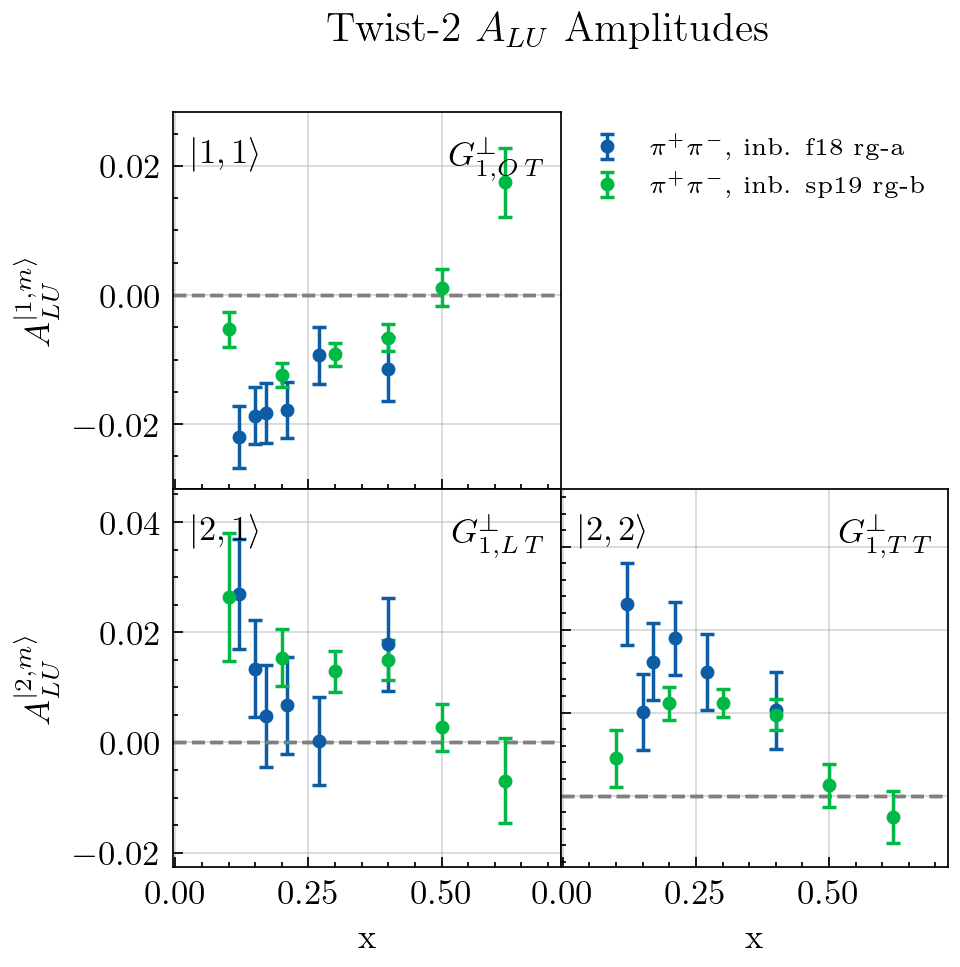

In [65]:
plot_PW("twist-2",data,[["Fall2018_RGA_inbending","precut","piplus_piminus","x","PW","standard"],
                       ["Spring2019_RGB_inbending","precut","piplus_piminus","xF","PW","standard"]],True)
#plot_PW("twist-3",data,[["MC_RGA_inbending","precut","piplus_pi0","z","PW","splot_sig"],
#                       ["MC_RGA_inbending","precut","piplus_pi0","z","PW","splot_bg"]],True)

In [66]:
import time
def write_title_page(f, title, author, description):
    f.write("\\begin{titlepage}\n")
    f.write("\\begin{center}\n")
    f.write(f"\\vspace*{{\\fill}}\n")
    f.write(f"\\textbf{{\\Huge {title}}}\\\\[0.5cm]\n")
    f.write(f"\\textbf{{\\Large {author}}}\\\\[0.5cm]\n")
    f.write("\\end{center}\n")
    f.write("\\thispagestyle{empty}\n")
    f.write("\\begin{center}\n")
    f.write(f"{description}\n")
    f.write("\\end{center}\n")
    f.write("\\vspace*{\\fill}\n")
    f.write(f"Generated on {time.strftime('%Y-%m-%d %H:%M:%S')}.\n")
    f.write("\\end{titlepage}\n")

# All bins RG-A
---

## All Channels

In [67]:
binvars=["x","Mh","z","pTtot","xF","Mx"]
plot_paths = []
do_plot=True
for binvar in binvars:
    for twist in ["twist-2","twist-3"]:
        plot_path = f"{project_dir}/{project_name}/plots/asym_pw/rga/default__{binvar}__{twist}.png"
        plot_paths.append(plot_path)
        if(not do_plot):
            continue
        plot_PW(twist,data,[["Fall2018_RGA_inbending","precut","piplus_piplus",binvar,"PW","standard"],
                            ["Fall2018_RGA_outbending","precut","piminus_piminus",binvar,"PW","standard"],
                            ["Fall2018_RGA_inbending","precut","piplus_piminus",binvar,"PW","standard"],
                            ["Fall2018_RGA_inbending","precut","piplus_pi0",binvar,"PW","splot_sig"],
                            ["Fall2018_RGA_outbending","precut","piminus_pi0",binvar,"PW","splot_sig"]
                            ],
                     drop_edges=(True if binvar!="Mx" else False),
                     out_plot=plot_path)

In [68]:
latex_file=f"{project_dir}/{project_name}/plots/asym_pw/rga.tex"
with open(latex_file, "w") as f:
    f.write("\\documentclass{article}\n")
    f.write("\\usepackage{graphicx}\n")
    f.write("\\usepackage{geometry}\n")
    f.write("\\usepackage{fancyhdr}\n")
    f.write("\\geometry{margin=1cm}\n") # Set the margin to 1 cm
    f.write("\\usepackage{subcaption}\n")
    f.write("\\usepackage[font=large]{caption}\n") # Set the caption font size to large
    f.write("\\begin{document}\n")
    write_title_page(f, "RG-A $\pi\pi$ Partial Waves ", "Gregory Matousek", "Each plot shows one of 12 partial wave components of the dihadron production beam spin asymmetry, extracted from the RG-A dataset at CLAS12.")
    for plot_path in plot_paths:
        binvar = os.path.basename(plot_path).split("__")[1]
        twist = os.path.basename(plot_path).split("__")[2].split(".")[0]
        f.write("\\begin{figure}\n")
        f.write("\\centering\n")
        f.write(f"\\includegraphics[width=0.95\\textwidth]{{{plot_path}}}\n")
        f.write(f"\\caption{{{binvar} -- {twist}}}\n")
        f.write("\\end{figure}\n")
        f.write("\\clearpage\n")
    f.write("\\end{document}\n")
    
# Save the current working directory
cwd = os.getcwd()

# Change the current working directory to the LaTeX directory
os.chdir(latex_dir)

# Compile the LaTeX file into a PDF
os.system(f"pdflatex {latex_file}")
os.system(f"pdflatex {latex_file}")

# Change the current working directory back to the original
os.chdir(cwd)

print(latex_file)

/work/clas12/users/gmat/clas12/clas12_dihadrons/projects/ana_v1/plots/asym_pw/rga.tex
This is pdfTeX, Version 3.14159265-2.6-1.40.20 (TeX Live 2019/Debian) (preloaded format=pdflatex)
 restricted \write18 enabled.
entering extended mode

(/work/clas12/users/gmat/clas12/clas12_dihadrons/projects/ana_v1/plots/asym_pw/
rga.tex
LaTeX2e <2020-02-02> patch level 2
L3 programming layer <2020-02-14>
(/usr/share/texlive/texmf-dist/tex/latex/base/article.cls
Document Class: article 2019/12/20 v1.4l Standard LaTeX document class
(/usr/share/texlive/texmf-dist/tex/latex/base/size10.clo))
(/usr/share/texlive/texmf-dist/tex/latex/graphics/graphicx.sty
(/usr/share/texlive/texmf-dist/tex/latex/graphics/keyval.sty)
(/usr/share/texlive/texmf-dist/tex/latex/graphics/graphics.sty
(/usr/share/texlive/texmf-dist/tex/latex/graphics/trig.sty)
(/usr/share/texlive/texmf-dist/tex/latex/graphics-cfg/graphics.cfg)
(/usr/share/texlive/texmf-dist/tex/latex/graphics-def/pdftex.def)))
(/usr/share/texlive/texmf-dist/te

## Rho producing channels

In [77]:
binvars=["x","Mh","z","pTtot","xF","Mx"]
plot_paths = []
do_plot=True
for binvar in binvars:
    for twist in ["twist-2","twist-3"]:
        plot_path = f"{project_dir}/{project_name}/plots/asym_pw/rga/rho_producers__{binvar}__{twist}.png"
        plot_paths.append(plot_path)
        if(not do_plot):
            continue
        plot_PW(twist,data,[
                            ["Fall2018_RGA_inbending","precut","piplus_piminus",binvar,"PW","standard"],
                            ["Fall2018_RGA_inbending","precut","piplus_pi0",binvar,"PW","splot_sig"],
                            ["Fall2018_RGA_outbending","precut","piminus_pi0",binvar,"PW","splot_sig"]
                            ],
                     drop_edges=(True if binvar!="Mx" else False),
                     out_plot=plot_path)

In [79]:
latex_file=f"{project_dir}/{project_name}/plots/asym_pw/rga_rho_producers.tex"
with open(latex_file, "w") as f:
    f.write("\\documentclass{article}\n")
    f.write("\\usepackage{graphicx}\n")
    f.write("\\usepackage{geometry}\n")
    f.write("\\usepackage{fancyhdr}\n")
    f.write("\\geometry{margin=1cm}\n") # Set the margin to 1 cm
    f.write("\\usepackage{subcaption}\n")
    f.write("\\usepackage[font=large]{caption}\n") # Set the caption font size to large
    f.write("\\begin{document}\n")
    write_title_page(f, "RG-A $\pi^+\pi^-$ , $\pi^+\pi^0$, $\pi^-\pi^0$ Partial Waves ", "Gregory Matousek", "Each plot shows one of 12 partial wave components of the dihadron production beam spin asymmetry, extracted from the RG-A dataset at CLAS12.")
    for plot_path in plot_paths:
        binvar = os.path.basename(plot_path).split("__")[1]
        twist = os.path.basename(plot_path).split("__")[2].split(".")[0]
        f.write("\\begin{figure}\n")
        f.write("\\centering\n")
        f.write(f"\\includegraphics[width=0.95\\textwidth]{{{plot_path}}}\n")
        f.write(f"\\caption{{{binvar} -- {twist}}}\n")
        f.write("\\end{figure}\n")
        f.write("\\clearpage\n")
    f.write("\\end{document}\n")
    
# Save the current working directory
cwd = os.getcwd()

# Change the current working directory to the LaTeX directory
os.chdir(latex_dir)

# Compile the LaTeX file into a PDF
os.system(f"pdflatex {latex_file}")
os.system(f"pdflatex {latex_file}")

# Change the current working directory back to the original
os.chdir(cwd)

print(latex_file)

/work/clas12/users/gmat/clas12/clas12_dihadrons/projects/ana_v1/plots/asym_pw/rga_rho_producers.tex
This is pdfTeX, Version 3.14159265-2.6-1.40.20 (TeX Live 2019/Debian) (preloaded format=pdflatex)
 restricted \write18 enabled.
entering extended mode

(/work/clas12/users/gmat/clas12/clas12_dihadrons/projects/ana_v1/plots/asym_pw/
rga_rho_producers.tex
LaTeX2e <2020-02-02> patch level 2
L3 programming layer <2020-02-14>
(/usr/share/texlive/texmf-dist/tex/latex/base/article.cls
Document Class: article 2019/12/20 v1.4l Standard LaTeX document class
(/usr/share/texlive/texmf-dist/tex/latex/base/size10.clo))
(/usr/share/texlive/texmf-dist/tex/latex/graphics/graphicx.sty
(/usr/share/texlive/texmf-dist/tex/latex/graphics/keyval.sty)
(/usr/share/texlive/texmf-dist/tex/latex/graphics/graphics.sty
(/usr/share/texlive/texmf-dist/tex/latex/graphics/trig.sty)
(/usr/share/texlive/texmf-dist/tex/latex/graphics-cfg/graphics.cfg)
(/usr/share/texlive/texmf-dist/tex/latex/graphics-def/pdftex.def)))
(/usr

## Like Pion Channels

In [80]:
binvars=["x","Mh","z","pTtot","xF","Mx"]
plot_paths = []
do_plot=True
for binvar in binvars:
    for twist in ["twist-2","twist-3"]:
        plot_path = f"{project_dir}/{project_name}/plots/asym_pw/rga/like_pi__{binvar}__{twist}.png"
        plot_paths.append(plot_path)
        if(not do_plot):
            continue
        plot_PW(twist,data,[
                            ["Fall2018_RGA_inbending","precut","piplus_piplus",binvar,"PW","standard"],
                            ["Fall2018_RGA_outbending","precut","piminus_piminus",binvar,"PW","standard"]
                            ],
                     drop_edges=(True if binvar!="Mx" else False),
                     out_plot=plot_path)

In [81]:
latex_file=f"{project_dir}/{project_name}/plots/asym_pw/rga_like_pi.tex"
with open(latex_file, "w") as f:
    f.write("\\documentclass{article}\n")
    f.write("\\usepackage{graphicx}\n")
    f.write("\\usepackage{geometry}\n")
    f.write("\\usepackage{fancyhdr}\n")
    f.write("\\geometry{margin=1cm}\n") # Set the margin to 1 cm
    f.write("\\usepackage{subcaption}\n")
    f.write("\\usepackage[font=large]{caption}\n") # Set the caption font size to large
    f.write("\\begin{document}\n")
    write_title_page(f, "RG-A $\pi^+\pi^+$ , $\pi^-\pi^-$ Partial Waves ", "Gregory Matousek", "Each plot shows one of 12 partial wave components of the dihadron production beam spin asymmetry, extracted from the RG-A dataset at CLAS12.")
    for plot_path in plot_paths:
        binvar = os.path.basename(plot_path).split("__")[1]
        twist = os.path.basename(plot_path).split("__")[2].split(".")[0]
        f.write("\\begin{figure}\n")
        f.write("\\centering\n")
        f.write(f"\\includegraphics[width=0.95\\textwidth]{{{plot_path}}}\n")
        f.write(f"\\caption{{{binvar} -- {twist}}}\n")
        f.write("\\end{figure}\n")
        f.write("\\clearpage\n")
    f.write("\\end{document}\n")
    
# Save the current working directory
cwd = os.getcwd()

# Change the current working directory to the LaTeX directory
os.chdir(latex_dir)

# Compile the LaTeX file into a PDF
os.system(f"pdflatex {latex_file}")
os.system(f"pdflatex {latex_file}")

# Change the current working directory back to the original
os.chdir(cwd)

print(latex_file)

/work/clas12/users/gmat/clas12/clas12_dihadrons/projects/ana_v1/plots/asym_pw/rga_like_pi.tex
This is pdfTeX, Version 3.14159265-2.6-1.40.20 (TeX Live 2019/Debian) (preloaded format=pdflatex)
 restricted \write18 enabled.
entering extended mode

(/work/clas12/users/gmat/clas12/clas12_dihadrons/projects/ana_v1/plots/asym_pw/
rga_like_pi.tex
LaTeX2e <2020-02-02> patch level 2
L3 programming layer <2020-02-14>
(/usr/share/texlive/texmf-dist/tex/latex/base/article.cls
Document Class: article 2019/12/20 v1.4l Standard LaTeX document class
(/usr/share/texlive/texmf-dist/tex/latex/base/size10.clo))
(/usr/share/texlive/texmf-dist/tex/latex/graphics/graphicx.sty
(/usr/share/texlive/texmf-dist/tex/latex/graphics/keyval.sty)
(/usr/share/texlive/texmf-dist/tex/latex/graphics/graphics.sty
(/usr/share/texlive/texmf-dist/tex/latex/graphics/trig.sty)
(/usr/share/texlive/texmf-dist/tex/latex/graphics-cfg/graphics.cfg)
(/usr/share/texlive/texmf-dist/tex/latex/graphics-def/pdftex.def)))
(/usr/share/texli

# All bins RG-B
---

In [69]:
binvars=["x","Mh","z","pTtot","xF","Mx"]
plot_paths = []
do_plot=True
for binvar in binvars:
    for twist in ["twist-2","twist-3"]:
        plot_path = f"{project_dir}/{project_name}/plots/asym_pw/rgb/default__{binvar}__{twist}.png"
        plot_paths.append(plot_path)
        if(not do_plot):
            continue
        plot_PW(twist,data,[["Spring2019_RGB_inbending","precut","piplus_piplus",binvar,"PW","standard"],
                            ["Fall2019_RGB_outbending","precut","piminus_piminus",binvar,"PW","standard"],
                            ["Spring2019_RGB_inbending","precut","piplus_piminus",binvar,"PW","standard"],
                            ["Spring2019_RGB_inbending","precut","piplus_pi0",binvar,"PW","splot_sig"],
                            ["Fall2019_RGB_outbending","precut","piminus_pi0",binvar,"PW","splot_sig"]
                            ],
                     drop_edges=(True if binvar!="Mx" else False),
                     out_plot=plot_path)

In [70]:
latex_file=f"{project_dir}/{project_name}/plots/asym_pw/rgb.tex"
with open(latex_file, "w") as f:
    f.write("\\documentclass{article}\n")
    f.write("\\usepackage{graphicx}\n")
    f.write("\\usepackage{geometry}\n")
    f.write("\\usepackage{fancyhdr}\n")
    f.write("\\geometry{margin=1cm}\n") # Set the margin to 1 cm
    f.write("\\usepackage{subcaption}\n")
    f.write("\\usepackage[font=large]{caption}\n") # Set the caption font size to large
    f.write("\\begin{document}\n")
    write_title_page(f, "RG-B $\pi\pi$ Partial Waves ", "Gregory Matousek", "Each plot shows one of 12 partial wave components of the dihadron production beam spin asymmetry, extracted from the RG-B dataset at CLAS12.")
    for plot_path in plot_paths:
        binvar = os.path.basename(plot_path).split("__")[1]
        twist = os.path.basename(plot_path).split("__")[2].split(".")[0]
        f.write("\\begin{figure}\n")
        f.write("\\centering\n")
        f.write(f"\\includegraphics[width=0.95\\textwidth]{{{plot_path}}}\n")
        f.write(f"\\caption{{{binvar} -- {twist}}}\n")
        f.write("\\end{figure}\n")
        f.write("\\clearpage\n")
    f.write("\\end{document}\n")
    
# Save the current working directory
cwd = os.getcwd()

# Change the current working directory to the LaTeX directory
os.chdir(latex_dir)

# Compile the LaTeX file into a PDF
os.system(f"pdflatex {latex_file}")
os.system(f"pdflatex {latex_file}")

# Change the current working directory back to the original
os.chdir(cwd)

print(latex_file)

/work/clas12/users/gmat/clas12/clas12_dihadrons/projects/ana_v1/plots/asym_pw/rgb.tex
This is pdfTeX, Version 3.14159265-2.6-1.40.20 (TeX Live 2019/Debian) (preloaded format=pdflatex)
 restricted \write18 enabled.
entering extended mode

(/work/clas12/users/gmat/clas12/clas12_dihadrons/projects/ana_v1/plots/asym_pw/
rgb.tex
LaTeX2e <2020-02-02> patch level 2
L3 programming layer <2020-02-14>
(/usr/share/texlive/texmf-dist/tex/latex/base/article.cls
Document Class: article 2019/12/20 v1.4l Standard LaTeX document class
(/usr/share/texlive/texmf-dist/tex/latex/base/size10.clo))
(/usr/share/texlive/texmf-dist/tex/latex/graphics/graphicx.sty
(/usr/share/texlive/texmf-dist/tex/latex/graphics/keyval.sty)
(/usr/share/texlive/texmf-dist/tex/latex/graphics/graphics.sty
(/usr/share/texlive/texmf-dist/tex/latex/graphics/trig.sty)
(/usr/share/texlive/texmf-dist/tex/latex/graphics-cfg/graphics.cfg)
(/usr/share/texlive/texmf-dist/tex/latex/graphics-def/pdftex.def)))
(/usr/share/texlive/texmf-dist/te

# Compare RG-A RG-B
---

In [71]:
binvars=["x","Mh","z","pTtot","xF","Mx"]
channels=["piplus_piplus","piplus_pi0","piplus_piminus","piminus_pi0","piminus_piminus"]
flags=["standard","splot_sig","standard","splot_sig","standard"]
cuts=["precut","precut","precut","precut","precut","precut"]
channels_RGA=["Fall2018_RGA_inbending","Fall2018_RGA_inbending","Fall2018_RGA_inbending","Fall2018_RGA_outbending","Fall2018_RGA_outbending"]
channels_RGB=["Spring2019_RGB_inbending","Spring2019_RGB_inbending","Spring2019_RGB_inbending","Fall2019_RGB_outbending","Fall2019_RGB_outbending"]
do_plot=True
plot_paths = []
for binvar in binvars:
    for channel,flag,cut,channel_RGA,channel_RGB in zip(channels,flags,cuts,channels_RGA,channels_RGB):
        for twist in ["twist-2","twist-3"]:
            plot_path = f"{project_dir}/{project_name}/plots/asym_pw/rgab/compare__{binvar}__{channel}__{twist}.png"
            plot_paths.append(plot_path)
            if(not do_plot):
                continue
            plot_PW(twist,data,[[channel_RGA,cut,channel,binvar,"PW",flag],
                                [channel_RGB,cut,channel,binvar,"PW",flag]],
                          drop_edges=True,
                          out_plot=plot_path,
                          custom_labels = [f"{channel} RG-A", f"{channel} RG-B"])

In [72]:
latex_file=f"{project_dir}/{project_name}/plots/asym_pw/rgab.tex"
with open(latex_file, "w") as f:
    f.write("\\documentclass{article}\n")
    f.write("\\usepackage{graphicx}\n")
    f.write("\\usepackage{geometry}\n")
    f.write("\\usepackage{fancyhdr}\n")
    f.write("\\geometry{margin=1.5cm}\n") # Set the margin to 1 cm
    f.write("\\usepackage{subcaption}\n")
    f.write("\\usepackage[font=large]{caption}\n") # Set the caption font size to large
    
    f.write("\\begin{document}\n")
    write_title_page(f, "RG-A vs. RG-B $\pi\pi$ Partial Waves ", "Gregory Matousek", "Each plot shows one of 12 partial wave components of the dihadron production beam spin asymmetry. We compare the asymmetries extracted from RG-A (proton target) and RG-B (deuteron target).")
    f.write("\\pagestyle{fancy}\n")
    f.write("\\fancyhf{}\n")
    f.write("\\fancyhead[L]{\\leftmark\\,\\,\\,\\,\\rightmark}\n")
    f.write("\\fancyhead[R]{\\thepage}\n")
    # Add a table of contents
    f.write("\\tableofcontents\n")
    f.write("\\clearpage\n")
    unique_channels = list(set([os.path.basename(plot_path).split("__")[2] for plot_path in plot_paths]))
    plts=0
    for channel in unique_channels:
        CHANNEL = channel.replace("piplus", "$\\pi^{+}$").replace("piminus", "$\\pi^{-}$").replace("pi0", "$\\pi^{0}$").replace("_", "")
        f.write(f"\\section{{{CHANNEL}}}\n")
        for plot_path in plot_paths:
            if os.path.basename(plot_path).split("__")[2] == channel:
                binvar = os.path.basename(plot_path).split("__")[1]
                twist = os.path.basename(plot_path).split("__")[3].split(".")[0]
                if(twist=="twist-2"):
                    if(plts==0):
                        f.write("\\clearpage\n")
                    else:
                        plts=1
                    f.write(f"\\subsection{{{binvar}}}\n")
                f.write("\\begin{figure}[ht]\n")
                f.write("\\centering\n")
                f.write(f"\\includegraphics[width=0.9\\textwidth]{{{plot_path}}}\n")
                f.write(f"\\caption{{{binvar} -- {twist}}}\n")
                f.write("\\end{figure}\n")
        
    f.write("\\end{document}\n")
    
    
# Save the current working directory
cwd = os.getcwd()

# Change the current working directory to the LaTeX directory
os.chdir(latex_dir)

# Compile the LaTeX file into a PDF
os.system(f"pdflatex {latex_file}")
os.system(f"pdflatex {latex_file}")

# Change the current working directory back to the original
os.chdir(cwd)

print(latex_file)

/work/clas12/users/gmat/clas12/clas12_dihadrons/projects/ana_v1/plots/asym_pw/rgab.tex
This is pdfTeX, Version 3.14159265-2.6-1.40.20 (TeX Live 2019/Debian) (preloaded format=pdflatex)
 restricted \write18 enabled.
entering extended mode

(/work/clas12/users/gmat/clas12/clas12_dihadrons/projects/ana_v1/plots/asym_pw/
rgab.tex
LaTeX2e <2020-02-02> patch level 2
L3 programming layer <2020-02-14>
(/usr/share/texlive/texmf-dist/tex/latex/base/article.cls
Document Class: article 2019/12/20 v1.4l Standard LaTeX document class
(/usr/share/texlive/texmf-dist/tex/latex/base/size10.clo))
(/usr/share/texlive/texmf-dist/tex/latex/graphics/graphicx.sty
(/usr/share/texlive/texmf-dist/tex/latex/graphics/keyval.sty)
(/usr/share/texlive/texmf-dist/tex/latex/graphics/graphics.sty
(/usr/share/texlive/texmf-dist/tex/latex/graphics/trig.sty)
(/usr/share/texlive/texmf-dist/tex/latex/graphics-cfg/graphics.cfg)
(/usr/share/texlive/texmf-dist/tex/latex/graphics-def/pdftex.def)))
(/usr/share/texlive/texmf-dist/

# Compare Datasets RG-A
---

In [73]:
binvars=["x","Mh","z","pTtot","xF","Mx"]
channels=["piplus_piplus","piplus_pi0","piplus_piminus","piminus_pi0","piminus_piminus"]
flags=["standard","splot_sig","standard","splot_sig","standard"]
plot_paths=[]
do_plot=True
for binvar in binvars:
    for channel,f in zip(channels,flags):
        for twist in ["twist-2","twist-3"]:
            plot_path=f"{project_dir}/{project_name}/plots/asym_pw/rga/compare_datasets__{channel}__{binvar}__{twist}.png"
            plot_paths.append(plot_path)
            if(not do_plot):
                continue
            plot_PW(twist,data,[["Fall2018_RGA_inbending","precut",channel,binvar,"PW",f],
                                ["Fall2018_RGA_outbending","precut",channel,binvar,"PW",f],
                                ["Spring2019_RGA_inbending","precut",channel,binvar,"PW",f]
                                ],
                         drop_edges=True,
                         out_plot=plot_path)

<ipython-input-64-85f3f8411da8>:156: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax.set_xlim(x_min - x_range * (factor - 1) / 2, x_max + x_range * (factor - 1) / 2)


In [74]:
latex_file=f"{project_dir}/{project_name}/plots/asym_pw/rga_compare_datasets.tex"
with open(latex_file, "w") as f:
    f.write("\\documentclass{article}\n")
    f.write("\\usepackage{graphicx}\n")
    f.write("\\usepackage{geometry}\n")
    f.write("\\usepackage{fancyhdr}\n")
    f.write("\\geometry{margin=1.5cm}\n") # Set the margin to 1 cm
    f.write("\\usepackage{subcaption}\n")
    f.write("\\usepackage[font=large]{caption}\n") # Set the caption font size to large
    
    f.write("\\begin{document}\n")
    write_title_page(f, "RG-A $\pi\pi$ Partial Waves (All Datasets)", "Gregory Matousek", "Each plot shows one of 12 partial wave components of the dihadron production beam spin asymmetry, extracted from the RG-A datasets at CLAS12. We show a comparison between the Fall2018 inbending (10.6 GeV), outbending (10.6 GeV), and Spring2019 inbending (10.2 GeV) data.")
    f.write("\\pagestyle{fancy}\n")
    f.write("\\fancyhf{}\n")
    f.write("\\fancyhead[L]{\\leftmark\\,\\,\\,\\,\\rightmark}\n")
    f.write("\\fancyhead[R]{\\thepage}\n")
    # Add a table of contents
    f.write("\\tableofcontents\n")
    plts=0
    unique_channels = list(set([os.path.basename(plot_path).split("__")[1] for plot_path in plot_paths]))
    for channel in unique_channels:
        CHANNEL = channel.replace("piplus", "$\\pi^{+}$").replace("piminus", "$\\pi^{-}$").replace("pi0", "$\\pi^{0}$").replace("_", "")
        f.write(f"\\section{{{CHANNEL}}}\n")
        for plot_path in plot_paths:
            if os.path.basename(plot_path).split("__")[1] == channel:
                binvar = os.path.basename(plot_path).split("__")[2]
                twist = os.path.basename(plot_path).split("__")[3].split(".")[0]
                if(twist=="twist-2"):
                    if(plts==0):
                        f.write("\\clearpage\n")
                    else:
                        plts=1
                    f.write(f"\\subsection{{{binvar}}}\n")
                f.write("\\begin{figure}[ht]\n")
                f.write("\\centering\n")
                f.write(f"\\includegraphics[width=0.95\\textwidth]{{{plot_path}}}\n")
                f.write(f"\\caption{{{binvar} -- {twist}}}\n")
                f.write("\\end{figure}\n")

    f.write("\\end{document}\n")
    
    
# Save the current working directory
cwd = os.getcwd()

# Change the current working directory to the LaTeX directory
os.chdir(latex_dir)

# Compile the LaTeX file into a PDF
os.system(f"pdflatex {latex_file}")
os.system(f"pdflatex {latex_file}")

# Change the current working directory back to the original
os.chdir(cwd)

print(latex_file)

/work/clas12/users/gmat/clas12/clas12_dihadrons/projects/ana_v1/plots/asym_pw/rga_compare_datasets.tex
This is pdfTeX, Version 3.14159265-2.6-1.40.20 (TeX Live 2019/Debian) (preloaded format=pdflatex)
 restricted \write18 enabled.
entering extended mode

(/work/clas12/users/gmat/clas12/clas12_dihadrons/projects/ana_v1/plots/asym_pw/
rga_compare_datasets.tex
LaTeX2e <2020-02-02> patch level 2
L3 programming layer <2020-02-14>
(/usr/share/texlive/texmf-dist/tex/latex/base/article.cls
Document Class: article 2019/12/20 v1.4l Standard LaTeX document class
(/usr/share/texlive/texmf-dist/tex/latex/base/size10.clo))
(/usr/share/texlive/texmf-dist/tex/latex/graphics/graphicx.sty
(/usr/share/texlive/texmf-dist/tex/latex/graphics/keyval.sty)
(/usr/share/texlive/texmf-dist/tex/latex/graphics/graphics.sty
(/usr/share/texlive/texmf-dist/tex/latex/graphics/trig.sty)
(/usr/share/texlive/texmf-dist/tex/latex/graphics-cfg/graphics.cfg)
(/usr/share/texlive/texmf-dist/tex/latex/graphics-def/pdftex.def)))

# Compare Datasets RG-B
---

In [75]:
binvars=["x","Mh","z","pTtot","xF","Mx"]
channels=["piplus_piplus","piplus_pi0","piplus_piminus","piminus_pi0","piminus_piminus"]
flags=["standard","splot_sig","standard","splot_sig","standard"]
plot_paths=[]
do_plot=True
for binvar in binvars:
    for channel,f in zip(channels,flags):
        for twist in ["twist-2","twist-3"]:
            plot_path=f"{project_dir}/{project_name}/plots/asym_pw/rgb/compare_datasets__{channel}__{binvar}__{twist}.png"
            plot_paths.append(plot_path)
            if(not do_plot):
                continue
            plot_PW(twist,data,[["Spring2019_RGB_inbending","precut",channel,binvar,"PW",f],
                                ["Fall2019_RGB_outbending","precut",channel,binvar,"PW",f],
                                ["Spring2020_RGB_inbending","precut",channel,binvar,"PW",f]
                                ],
                         drop_edges=True,
                         out_plot=plot_path)

In [76]:
latex_file=f"{project_dir}/{project_name}/plots/asym_pw/rgb_compare_datasets.tex"
with open(latex_file, "w") as f:
    f.write("\\documentclass{article}\n")
    f.write("\\usepackage{graphicx}\n")
    f.write("\\usepackage{geometry}\n")
    f.write("\\usepackage{fancyhdr}\n")
    f.write("\\geometry{margin=1.5cm}\n") # Set the margin to 1 cm
    f.write("\\usepackage{subcaption}\n")
    f.write("\\usepackage[font=large]{caption}\n") # Set the caption font size to large
    
    f.write("\\begin{document}\n")
    write_title_page(f, "RG-B $\pi\pi$ Partial Waves (All Datasets)", "Gregory Matousek", "Each plot shows one of 12 partial wave components of the dihadron production beam spin asymmetry, extracted from the RG-B datasets at CLAS12. We show a comparison between the Spring2019 inbending (10.6 GeV), Fall2019 outbending (10.4 GeV), and Spring2020 inbending (10.4 GeV) data.")
    f.write("\\pagestyle{fancy}\n")
    f.write("\\fancyhf{}\n")
    f.write("\\fancyhead[L]{\\leftmark\\,\\,\\,\\,\\rightmark}\n")
    f.write("\\fancyhead[R]{\\thepage}\n")
    # Add a table of contents
    f.write("\\tableofcontents\n")
    plts=0
    unique_channels = list(set([os.path.basename(plot_path).split("__")[1] for plot_path in plot_paths]))
    for channel in unique_channels:
        CHANNEL = channel.replace("piplus", "$\\pi^{+}$").replace("piminus", "$\\pi^{-}$").replace("pi0", "$\\pi^{0}$").replace("_", "")
        f.write(f"\\section{{{CHANNEL}}}\n")
        for plot_path in plot_paths:
            if os.path.basename(plot_path).split("__")[1] == channel:
                binvar = os.path.basename(plot_path).split("__")[2]
                twist = os.path.basename(plot_path).split("__")[3].split(".")[0]
                if(twist=="twist-2"):
                    if(plts==0):
                        f.write("\\clearpage\n")
                    else:
                        plts=1
                    f.write(f"\\subsection{{{binvar}}}\n")
                f.write("\\begin{figure}[ht]\n")
                f.write("\\centering\n")
                f.write(f"\\includegraphics[width=0.95\\textwidth]{{{plot_path}}}\n")
                f.write(f"\\caption{{{binvar} -- {twist}}}\n")
                f.write("\\end{figure}\n")
                f.write("\\clearpage\n")

    f.write("\\end{document}\n")
    
    
# Save the current working directory
cwd = os.getcwd()

# Change the current working directory to the LaTeX directory
os.chdir(latex_dir)

# Compile the LaTeX file into a PDF
os.system(f"pdflatex {latex_file}")
os.system(f"pdflatex {latex_file}")

# Change the current working directory back to the original
os.chdir(cwd)

print(latex_file)

/work/clas12/users/gmat/clas12/clas12_dihadrons/projects/ana_v1/plots/asym_pw/rgb_compare_datasets.tex
This is pdfTeX, Version 3.14159265-2.6-1.40.20 (TeX Live 2019/Debian) (preloaded format=pdflatex)
 restricted \write18 enabled.
entering extended mode

(/work/clas12/users/gmat/clas12/clas12_dihadrons/projects/ana_v1/plots/asym_pw/
rgb_compare_datasets.tex
LaTeX2e <2020-02-02> patch level 2
L3 programming layer <2020-02-14>
(/usr/share/texlive/texmf-dist/tex/latex/base/article.cls
Document Class: article 2019/12/20 v1.4l Standard LaTeX document class
(/usr/share/texlive/texmf-dist/tex/latex/base/size10.clo))
(/usr/share/texlive/texmf-dist/tex/latex/graphics/graphicx.sty
(/usr/share/texlive/texmf-dist/tex/latex/graphics/keyval.sty)
(/usr/share/texlive/texmf-dist/tex/latex/graphics/graphics.sty
(/usr/share/texlive/texmf-dist/tex/latex/graphics/trig.sty)
(/usr/share/texlive/texmf-dist/tex/latex/graphics-cfg/graphics.cfg)
(/usr/share/texlive/texmf-dist/tex/latex/graphics-def/pdftex.def)))